In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
df = pd.read_csv('Train_SU63ISt.csv')

df.head()                             #Printing head

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [2]:
df.tail()            # we are having 2 years of data(2012-2014) with count of travellers and we need to predict for future

,ID,Datetime,Count
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580
18287,18287,25-09-2014 23:00,534


In [3]:
train = df[0:10392]   # split the data Aug2012 -oct2013 into train
test = df[10392:]


In [4]:
df.Timestamp = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M') 
df.index = df.Timestamp                                                      #Aggregating the dataset at daily level
df = df.resample('D').mean()
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
train = train.resample('D').mean() 
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 
test = test.resample('D').mean()


C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.
C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


In [6]:
train.tail()

,ID,Count
Datetime,,
2013-10-27,10283.5,86.750000
2013-10-28,10307.5,147.333333
2013-10-29,10331.5,167.916667
2013-10-30,10355.5,157.250000
2013-10-31,10379.5,142.000000


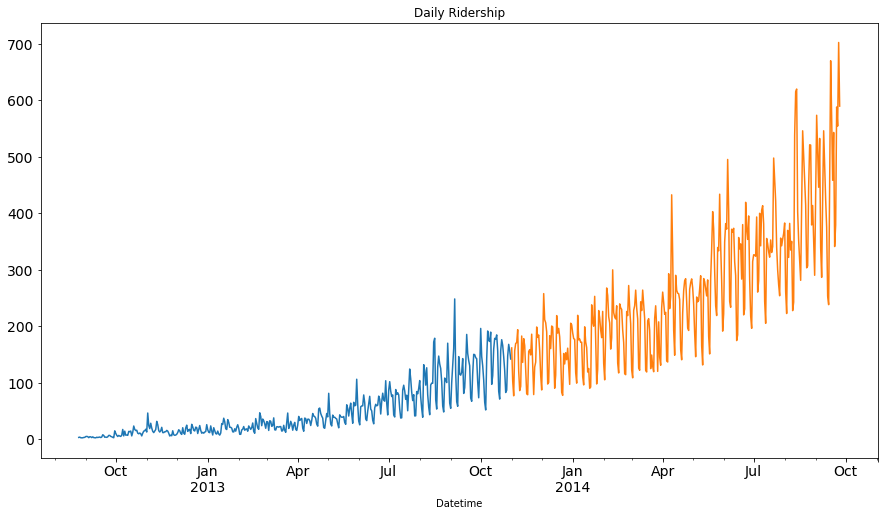

In [7]:
#Plotting data
train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
test.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()

C:\Users\bhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  after removing the cwd from sys.path.


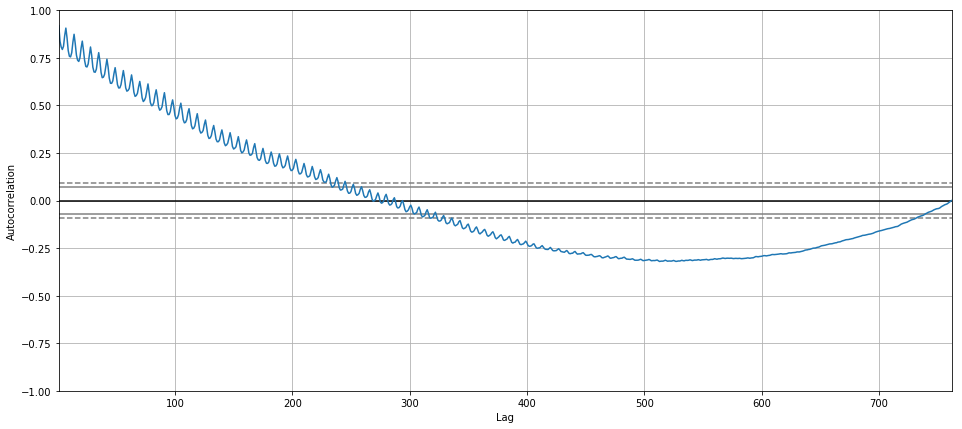

In [8]:
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(16, 7))
plot_lags= 25
autocorrelation_plot(df.Count)

Test Statistic                   2.986351
p-value                          1.000000
#Lags Used                      20.000000
Number of Observations Used    741.000000
Critical Value (1%)             -3.439206
Critical Value (5%)             -2.865448
Critical Value (10%)            -2.568851
dtype: float64


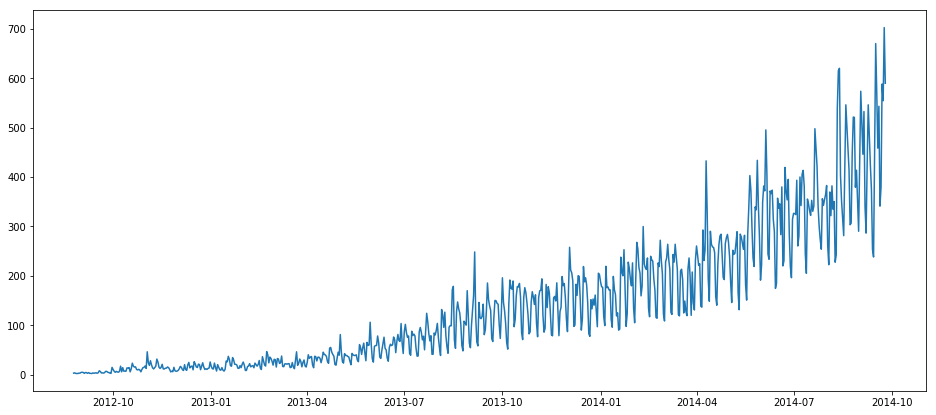

In [9]:
from statsmodels.tsa.stattools import adfuller

def stationarity_test(data):
    dftest = adfuller(data.Count, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    plt.figure(figsize=(16, 7))
    plt.plot(data.index, data.Count)
    plt.show()
 
stationarity_test(df)                    #Series is not stationary

In [10]:
decompose = pd.DataFrame(df.Count)
decompose.index = df.index
decompose.head(10)


,Count
Datetime,
2012-08-25,3.166667
2012-08-26,3.666667
2012-08-27,2.583333
2012-08-28,2.416667
2012-08-29,2.500000
2012-08-30,3.083333
2012-08-31,3.250000
2012-09-01,4.666667
2012-09-02,4.916667


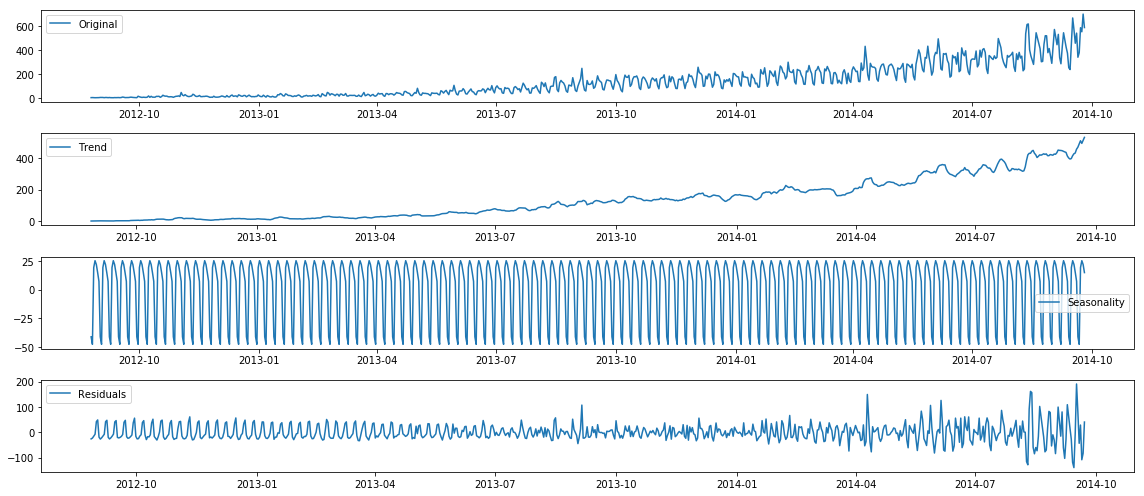

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(decompose)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(16, 7))
plt.subplot(411)
plt.plot(df["Count"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Test Statistic                  -2.160092
p-value                          0.221047
#Lags Used                      20.000000
Number of Observations Used    741.000000
Critical Value (1%)             -3.439206
Critical Value (5%)             -2.865448
Critical Value (10%)            -2.568851
dtype: float64


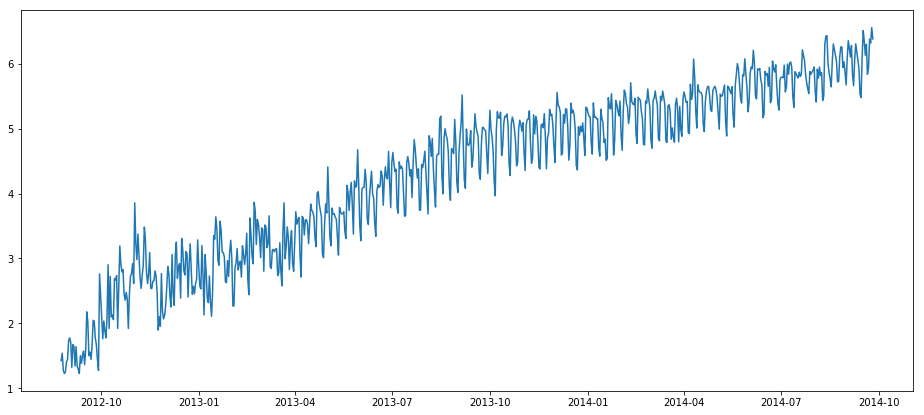

In [13]:
import math
log_train = decompose
log_train = log_train["Count"].apply(lambda x: math.log(x+1))
log_train = pd.DataFrame(log_train)                                #variance seems constant
stationarity_test(log_train)    

Test Statistic                -9.083142e+00
p-value                        4.005720e-15
#Lags Used                     1.900000e+01
Number of Observations Used    7.420000e+02
Critical Value (1%)           -3.439194e+00
Critical Value (5%)           -2.865443e+00
Critical Value (10%)          -2.568848e+00
dtype: float64


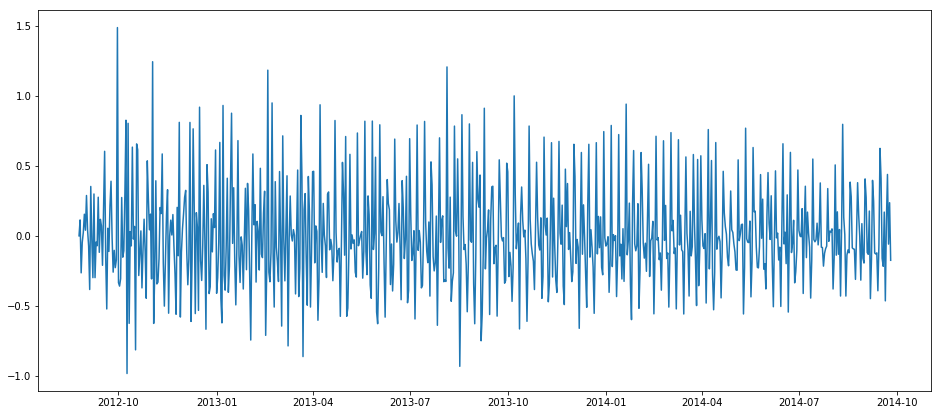

In [14]:
first_diff = log_train["Count"] - log_train["Count"].shift(1)
first_diff = first_diff.fillna(0)
first_diff = pd.DataFrame(first_diff)                           
stationarity_test(first_diff)

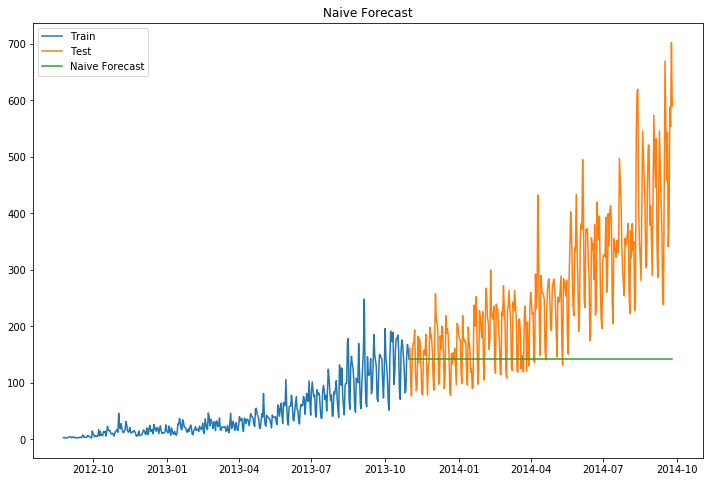

In [18]:
dd= np.asarray(train.Count)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()


In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Count, y_hat.naive))
print(rms)


168.10065982822383


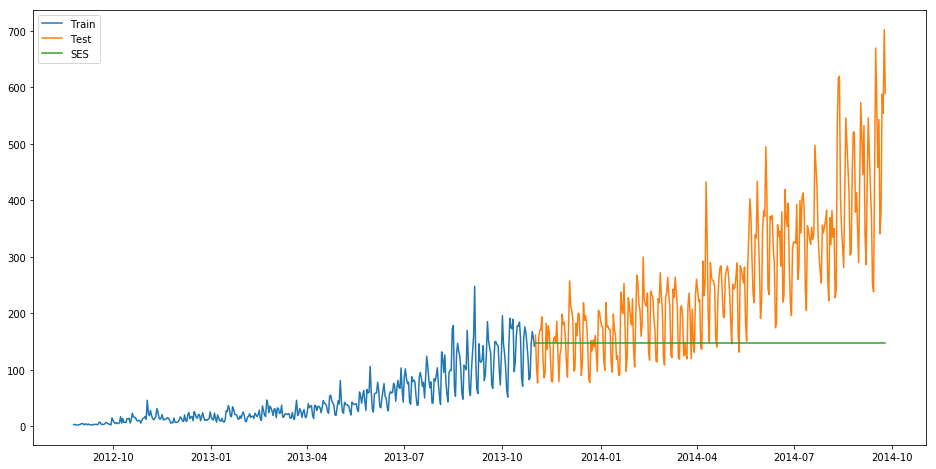

In [21]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [22]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.SES))
print(rms)


164.61063054927618


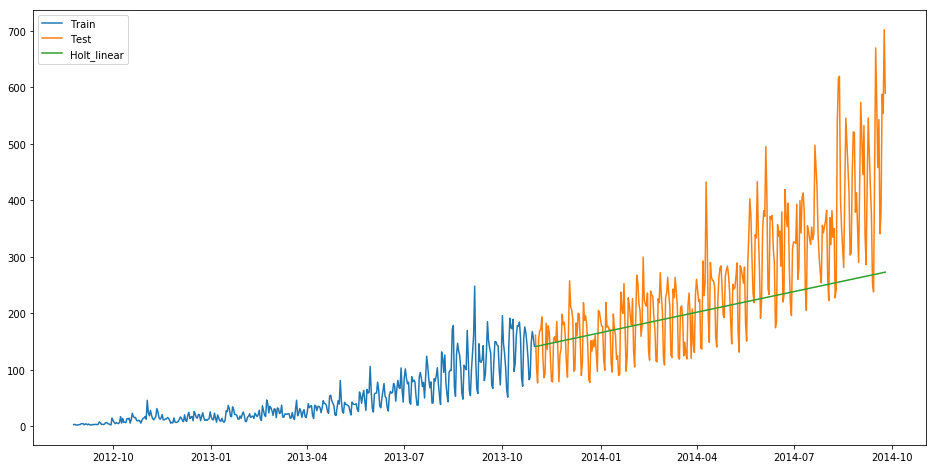

In [23]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [24]:
rms = sqrt(mean_squared_error(test.Count,y_hat_avg['Holt_linear'] ))
print(rms)

107.23394793380741


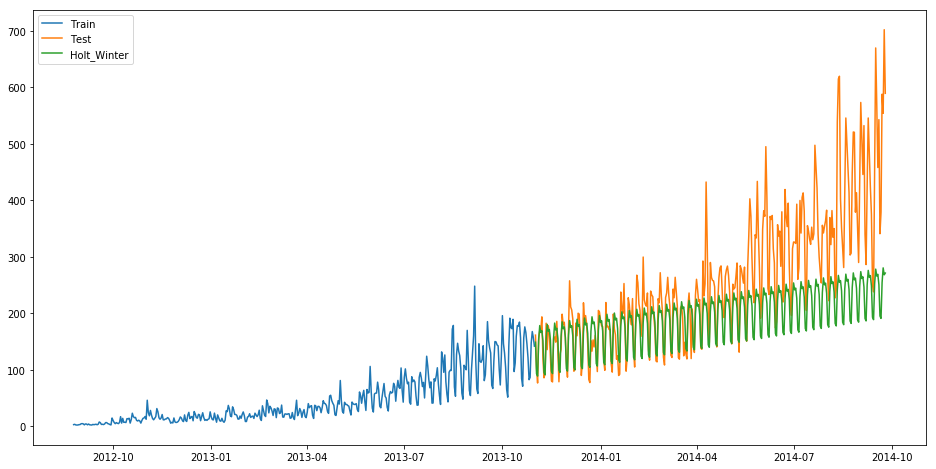

In [25]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [26]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_Winter))
print(rms)


108.04059918591852
